In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import operator
from functools import reduce
from functools import partial

import time
import matplotlib.pyplot as plt
from utilities3 import *

In [2]:
def compl_mul2d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    return torch.einsum("bixy,ioxy->boxy", a, b)

class LowRank2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LowRank2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.phi = DenseNet([2, 64, 128, in_channels*out_channels], torch.nn.ReLU)
        self.psi = DenseNet([2, 64, 128, in_channels*out_channels], torch.nn.ReLU)

    def get_grid(self, S1, S2, batchsize, device):
        gridx = torch.tensor(np.linspace(0, 1, S1), dtype=torch.float)
        gridx = gridx.reshape(1, S1, 1).repeat([batchsize, 1, S2])
        gridy = torch.tensor(np.linspace(0, 1, S2), dtype=torch.float)
        gridy = gridy.reshape(1, 1, S2).repeat([batchsize, S1, 1])
        return torch.stack((gridx, gridy), dim=-1).to(device)

    def forward(self, x, gridy=None):
        # x (batch, channel, x, y)
        # y (Ny, 2)
        batchsize, size1, size2 = x.shape[0], x.shape[2], x.shape[3]

        gridx = self.get_grid(S1=size1, S2=size2, batchsize=1, device=x.device).reshape(size1 * size2, 2)
        if gridy==None:
            gridy = self.get_grid(S1=size1, S2=size2, batchsize=1, device=x.device).reshape(size1 * size2, 2)
        Nx = size1 * size2
        Ny = gridy.shape[0]

        phi_eval = self.phi(gridx).reshape(Nx, self.out_channels, self.in_channels)
        psi_eval = self.psi(gridy).reshape(Ny, self.out_channels, self.in_channels)
        x = x.reshape(batchsize, self.in_channels, Nx)

        x = torch.einsum('noi,bin,moi->bom', phi_eval, x, psi_eval) / Nx
        return x

In [3]:
class SpectralConv2d(nn.Module):
    '''
    Single Fourier Neural Operator layer, performs FFT on input, etc
    '''
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x, size=None):

        if size==None:
            size = (x.size(2), x.size(3))

        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[2,3])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, size[0], size[1]//2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(size[0], size[1]), dim=[2,3])

        return x

In [4]:
class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2, width, in_dim=3, out_dim=1):
        super(SimpleBlock2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2

        self.width_list = [width*2//4, width*3//4, width*4//4, width*4//4, width*5//4]

        self.fc0 = nn.Linear(in_dim, self.width_list[0])

        self.conv0 = SpectralConv2d(self.width_list[0], self.width_list[1], self.modes1*4//4, self.modes2*4//4)
        self.conv1 = SpectralConv2d(self.width_list[1], self.width_list[2], self.modes1*3//4, self.modes2*3//4)
        self.conv2 = SpectralConv2d(self.width_list[2], self.width_list[3], self.modes1*2//4, self.modes2*2//4)
        self.conv3 = SpectralConv2d(self.width_list[3], self.width_list[4], self.modes1*1//4, self.modes2*1//4)
        self.w0 = nn.Conv1d(self.width_list[0], self.width_list[1], 1)
        self.w1 = nn.Conv1d(self.width_list[1], self.width_list[2], 1)
        self.w2 = nn.Conv1d(self.width_list[2], self.width_list[3], 1)
        self.w3 = nn.Conv1d(self.width_list[3], self.width_list[4], 1)
        self.k3 = LowRank2d(self.width_list[3], self.width_list[4])

        self.fc1 = nn.Linear(self.width_list[4], self.width_list[4]*2)
        # self.fc2 = nn.Linear(self.width_list[4]*2, self.width_list[4]*2)
        self.fc3 = nn.Linear(self.width_list[4]*2, out_dim)

    def forward(self, x, sub=1):

        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]
        size = (size_x*sub, size_y*sub)

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width_list[0], size_x*size_y)).view(batchsize, self.width_list[1], size_x, size_y)
        # x2 = F.interpolate(x2, size=size_list[1], mode='bilinear')
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width_list[1], size_x*size_y)).view(batchsize, self.width_list[2], size_x, size_y)
        # x2 = F.interpolate(x2, size=size_list[2], mode='bilinear')
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width_list[2], size_x*size_y)).view(batchsize, self.width_list[3], size_x, size_y)
        # x2 = F.interpolate(x2, size=size_list[3], mode='bilinear')
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv3(x, size)
        x2 = self.w3(x.view(batchsize, self.width_list[3], size_x*size_y)).view(batchsize, self.width_list[4], size_x, size_y)
        # x2 = self.k3(x).reshape(batchsize, self.width_list[4], size_x, size_y)
        # x2 = F.interpolate(x2, size=size, mode='bilinear')
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.elu(x)
        x = self.fc3(x)
        return x

    def get_grid(self, S, batchsize, device):
        gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridx = gridx.reshape(1, 1, S, 1).repeat([batchsize, 1, 1, S])
        gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, S).repeat([batchsize, 1, S, 1])

        return torch.cat((gridx, gridy), dim=1).to(device)

class Net2d(nn.Module):
    def __init__(self, modes, width):
        super(Net2d, self).__init__()

        self.conv1 = SimpleBlock2d(modes, modes,  width)


    def forward(self, x, sub=1):
        x = self.conv1(x, sub)
        return x


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [5]:
class Net2d_FC(nn.Module):
    def __init__(self, modes, width):
        super(Net2d_FC, self).__init__()

        self.conv1 = SimpleBlock2d(modes, modes,  width)


    def forward(self, x, sub=1, pad_size = 5):
        padt = torch.zeros((x.shape[0], pad_size, x.shape[2]))
        padt = padt.cuda()
        x = torch.cat([x, padt], 1)
        x = self.conv1(x, sub)
        x = x.narrow(1, 0, x.shape[1]-pad_size)
        return x


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [6]:
ntrain = 1500
ntest = 2048-1500

# out of 2048 total
train_size = 1500

# sampling stuff
sub = 8 #subsampling rate
h = 1024 // sub
s = h
# sampling over time
sub_t = 1
T = 101 // sub_t

pad_size = T // 20

batch_size = 1
learning_rate = 0.001

epochs = 5
step_size = 500
gamma = 0.5

modes = 20
width = 64

LOG_INTERVAL = 100

In [7]:
data_loader = MatReader('data/burgers_v100_t100_r1024_N2048.mat')
# x_data = data_loader.read_field('input')
# y_data = data_loader.read_field('output')

x_data = data_loader.read_field('input')[:,::sub]
y_data = data_loader.read_field('output')[:,::sub_t,::sub]

print(x_data.shape, torch.mean(torch.abs(x_data)))
print(y_data.shape, torch.mean(torch.abs(y_data)))

x_train = x_data[:train_size]
y_train = y_data[:train_size]
x_test = x_data[train_size:]
y_test = y_data[train_size:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

c:\users\derek\appdata\local\programs\python\python39\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


torch.Size([2048, 128]) tensor(0.2198)
torch.Size([2048, 101, 128]) tensor(0.1572)
torch.Size([1500, 128])
torch.Size([1500, 101, 128])
torch.Size([548, 128])
torch.Size([548, 101, 128])


In [8]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)
y_test = y_normalizer.encode(y_test)

# Method from pino_burger_fdm
# Repeats the 1D input to make it 2D
x_train = x_train.reshape(ntrain, 1, s).repeat([1,T,1])
x_test = x_test.reshape(ntest, 1, s).repeat([1,T,1])

# Padded data
padt_train = torch.zeros((ntrain, pad_size, s))
x_train_pad = torch.cat([x_train, padt_train], 1)

padt_test = torch.zeros((ntest, pad_size, s))
x_test_pad = torch.cat([x_test, padt_test], 1)

# Adding grids
gridt = torch.tensor(np.linspace(0,1,T), dtype=torch.float)
gridt = gridt.reshape(1, T, 1)
gridx = torch.tensor(np.linspace(0, 1, s+1)[:-1], dtype=torch.float)
gridx = gridx.reshape(1, 1, s)

gridt_pad = torch.tensor(np.linspace(0,1,T+pad_size), dtype = torch.float)
gridt_pad = gridt_pad.reshape(1,T+pad_size,1)
gridx_pad = torch.tensor(np.linspace(0,1,s), dtype = torch.float)
gridx_pad = gridx_pad.reshape(1,1,s)

# Stacking grids on data
x_train = torch.stack([x_train, gridx.repeat([ntrain, T, 1]), gridt.repeat([ntrain, 1, s])], dim=3)
x_test = torch.stack([x_test, gridx.repeat([ntest, T, 1]), gridt.repeat([ntest, 1, s])], dim=3)

x_train_pad = torch.stack([x_train_pad, gridx_pad.repeat([ntrain, T+pad_size, 1]), gridt_pad.repeat([ntrain, 1, s])], dim = 3)
x_test_pad = torch.stack([x_test_pad, gridx_pad.repeat([ntest, T+pad_size, 1]), gridt_pad.repeat([ntest, 1, s])], dim = 3)

print(x_train.shape)
print(x_test.shape)
print(x_train_pad.shape)
print(x_test_pad.shape)

#not done
# x_train_pad = torch.stack([x_train_pad, gridx.repeat([ntrain, T, 1]), gridt.repeat([ntrain, 1, s])], dim=3)
# x_test_pad = torch.stack([x_test_pad, gridx.repeat([ntest, T, 1]), gridt.repeat([ntest, 1, s])], dim=3)

# Method from fourier_2d
# grids = []
# grids.append(np.linspace(0, 1, s))
# grids.append(np.linspace(0, 1, s))
# grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
# grid = grid.reshape(1,s,s,2)
# grid = torch.tensor(grid, dtype=torch.float)
# x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
# x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_pad, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_pad, y_test), batch_size=batch_size, shuffle=False)

torch.Size([1500, 101, 128, 3])
torch.Size([548, 101, 128, 3])
torch.Size([1500, 106, 128, 3])
torch.Size([548, 106, 128, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


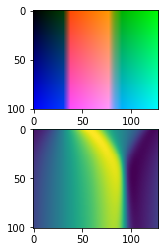

In [75]:
fig = plt.figure()

plt.subplot(2,1,1)
plt.imshow(x_train[0], interpolation = 'none')

plt.subplot(2,1,2)
plt.imshow(y_train[0], interpolation = 'none')

In [84]:
model = Net2d(modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

5051713


In [ ]:
model = Net2d(modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)

In [86]:
train_loss = []
test_loss = []
def train(epoch):
    model.train()
    start_time = time.perf_counter()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()

        output = model(data)
        
        # remove padding
        output = output.narrow(1, 0, T)
        
        loss = F.mse_loss(output.view(batch_size,-1), target.view(batch_size,-1), reduction = 'sum')

        total_loss += loss.item()

        loss.backward()

        optimizer.step()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Time: {:.1f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item(),
                time.perf_counter() - start_time
            ))
    scheduler.step()
    train_loss.append(total_loss / ntrain)


def test():
    model.eval()
    loss = 0
    start_time = time.perf_counter()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            
            # remove padding
            output = output.narrow(1, 0, T)
            
            loss += F.mse_loss(output.view(batch_size, -1), target.view(batch_size,-1), reduction = 'sum').item()
    
    runtime = time.perf_counter() - start_time
    loss /= len(test_loader.dataset)
    print('Average Test Loss: {:.8f} Time: {:.1f}'.format(
        loss,
        runtime
    ))
    test_loss.append(loss)

In [87]:
test()
for epoch in range(1, epochs+1):
    train(epoch)
    test()

Average Test Loss: 11630.03673709 Time: 5.3
Train Epoch: 1 [100/1500 (7%)] Loss: 2165.570252 Time: 3.4
Train Epoch: 1 [200/1500 (13%)] Loss: 463.253793 Time: 6.9
Train Epoch: 1 [300/1500 (20%)] Loss: 204.602452 Time: 10.5
Train Epoch: 1 [400/1500 (27%)] Loss: 252.328790 Time: 14.4
Train Epoch: 1 [500/1500 (33%)] Loss: 212.045427 Time: 18.3
Train Epoch: 1 [600/1500 (40%)] Loss: 54.806793 Time: 22.3
Train Epoch: 1 [700/1500 (47%)] Loss: 171.622836 Time: 26.2
Train Epoch: 1 [800/1500 (53%)] Loss: 70.443295 Time: 30.1
Train Epoch: 1 [900/1500 (60%)] Loss: 40.470965 Time: 35.1
Train Epoch: 1 [1000/1500 (67%)] Loss: 30.776956 Time: 40.3
Train Epoch: 1 [1100/1500 (73%)] Loss: 45.354607 Time: 47.8
Train Epoch: 1 [1200/1500 (80%)] Loss: 36.827790 Time: 55.0
Train Epoch: 1 [1300/1500 (87%)] Loss: 33.337732 Time: 59.2
Train Epoch: 1 [1400/1500 (93%)] Loss: 29.841184 Time: 63.1
Average Test Loss: 32.55310680 Time: 6.3
Train Epoch: 2 [100/1500 (7%)] Loss: 25.868529 Time: 3.8
Train Epoch: 2 [200/150

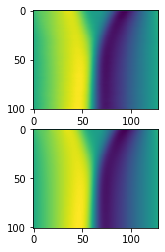

In [80]:
data, target = next(iter(test_loader))
data = data.cuda()
output = model(data)
output = output.narrow(1, 0, T)
output = output.cpu().detach().numpy()

output = output.reshape((T,128))
target = target.reshape((T,128))

fig = plt.figure()

plt.subplot(2,1,1)
plt.imshow(output, interpolation = 'none')


plt.subplot(2,1,2)
plt.imshow(target, interpolation = 'none')


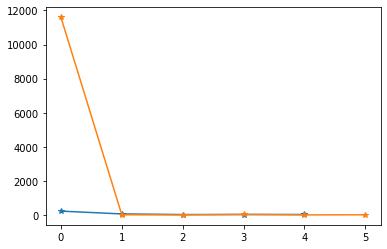

In [81]:
fig = plt.figure()

plt.plot(train_loss, "*-")
plt.plot(test_loss, "*-")
plt.show()